In [1]:
from utils import prepare_pauli_operator,mean_and_error,parallel_for
from tqdm import tqdm
from math import sqrt
import networkx as nx
from functools import reduce # Valid in Python 2.6+, required in Python 3
import operator
from graphstates import *
import numpy as np
import itertools 
from utils import prepare_crazy_cross,prepare_path_cross
def prod(gen,init=1):
    return reduce(operator.mul, gen, init)
from tqdm import *
import pickle
import matplotlib as plt
from qutip.metrics import fidelity
from IPython.display import clear_output
import random
import os
import time
import matplotlib.pyplot as plt
import pickle
from matplotlib import rc
import numpy as np

import matplotlib.path as mpath
from matplotlib import rc

def random_sign():
    return random.choice([1,-1])

def e_z_check(args):
    N,edges,Pedge,Pz,tomeasure,terminal,stabgens,axis=args
    #when paralellized, the initial random seed is correlated across subprocesses. hence the following fix:
    np.random.seed((os.getpid() * int(time.time())) % 123456789) 
    random.seed(((os.getpid() * int(time.time())) % 123456789))
    gse=subgraph_and_z_monte_carlo_ensemble(N,edges,Pedge,Pz,9,True)
    signs=[0 for v in range(N)]
    
    #measure the non-terminal qubits with random signs (uniform probability for all stabilizer-consistent):
    for sg in stabgens:
        sign=random_sign()
        for v in sg:
            assert v in tomeasure
            assert signs[v]==0
            gse.measure_pauli_operator(v,axis,sign)
            signs[v]=sign

        prodsigns=prod(signs[v] for v in sg)
        assert prodsigns==1 #just to be sure... consistency with the stabilizer structure

    #but there could be qubits not involved in any stabilizer operator. let's measure them too:
    for v in tomeasure: 
        if signs[v]==0:
            sign=random_sign()
            gse.measure_pauli_operator(v,axis,sign)
            signs[v]=sign
    ss=[]

    for sg in stabgens:
        ss.append(prod(signs[v] for v in sg))
    consistent=all(sign==1 for sign in ss) #yet another consistency check
    if consistent:
        st1=gse.get_reduced_state(terminal,normalized=True)
        st2=gse.states[-1]['state'].get_reduced_state(terminal,normalized=True)
        con=fidelity(st1,st2)
    else:
        assert False #should not happen! and thankfully does not.
        con=0
    
    #the signs were taken to be uniform (with consistency constraint). this may not the be the prob. dist.
    # observed in an experiment. but if we're interested in mean fidelity, simple weighting by the end state norm works:
    weight=gse.probability() 
    return (con,weight)

def graphcheck(G,terminal,tomeasure,stabgens,no_measurement_runs,prob,draw=False):
    N=G.order()
    if draw:
        nx.draw(G,with_labels=True)
    edges=G.edges

    eresults=parallel_for(
        e_z_check,[(N,edges,prob,0,tomeasure,terminal,stabgens,'x') for _ in range(no_measurement_runs)],
        4 #n.o. subprocesses
    )
    
    cons=np.array([con for (con,weight) in eresults])
    weights=np.array([weight for (con,weight) in eresults])

    
    return (cons,weights)

def find_closest(target, numbers):
    """
    Find the number in the list closest to the target number.

    Args:
    target (int or float): The number to find the closest to.
    numbers (list of int or float): The list of numbers to search in.

    Returns:
    int or float: The number from the list closest to the target.
    """
    return min(numbers, key=lambda x: abs(x - target))

In [2]:
def crazyghzcheck(length,nghz,eps,no_measurement_runs=100,clear=True,draw=False):
    G=prepare_crazy_cross(length,nghz)
    N=G.order()
    edges=G.edges
    cons={}
    postselcons={}
    terminal=list(range(nghz))
    tomeasure=np.arange(nghz,N)
    stabgens=np.reshape(np.arange(nghz,N),((N-nghz)//2,2)) #X-chain stabilizer generators, used for parity checks

    ret= graphcheck(G,terminal,tomeasure,stabgens,no_measurement_runs,eps,draw=draw)
    if clear:
        clear_output(wait=True)
    return ret

def pathghzcheck(length,nghz,eps,no_measurement_runs=100,clear=True,draw=False):
    G=prepare_path_cross(length,nghz)
    N=G.order()
    edges=G.edges
    cons={}
    postselcons={}
    terminal=list(range(nghz))
    tomeasure=np.arange(nghz,N)
    stabgens=[] #path graph doesn't have X-chain stabilizers
    ret= graphcheck(G,terminal,tomeasure,stabgens,no_measurement_runs,eps,draw=draw)
    if clear:
        clear_output(wait=True)
    return ret


In [4]:
def genres(probres,ps,fun): # generate data for the aforementioned structures 
    for i in range(len(ps)):
        p=ps[i]
        print('Doing p {} {}/{}'.format(p,i,len(ps)))
        if len(probres.keys())>0:
            pp=find_closest(p,probres.keys())
            if abs(p-pp)<1e-4:
                p=pp
        r=fun(p)
        if p not in probres:
            probres[p]=r
        else:
            e1,w1=probres[p]
            e2,w2=r
            e=np.concatenate((e1,e2))
            w=np.concatenate((w1,w2))
            probres[p]=(e,w)
def refine(res,filename,fun,maxn=100000000000): 
    # refine existing data, with low-accumulated prob. datapoints refined first.
    for _ in range(maxn):
        ps=[]
        tks=res.keys()

        #select 5 datapoints with lowest accumulated probability of observing stabilizer-consistent sign structures:
        for p in sorted(tks,key=(lambda p: sum(res[p][1])))[:5]:
            ps.append(p)
            print((p,np.sum(res[p][1])))

        genres(res,ps,fun)
        
        with open(filename, 'wb') as file: #save the incremental result
            pickle.dump(res, file)

In [7]:
#data generation part. In rough terms, 
# - split the probability range into discrete points (array ps),
# - generate data points for each edge loss probability p in ps
# - then improve data points with low overall total weight (heurestic for low data quality)
# warning: very long calculation! you probably want to split ps into several calculations, 
# e.g. 10 datapoints between 0 and 0.1, 10 datapoints betwen 0.1 and 0.4, 10 datapoints between 0.4 and 0.5,...
# hence if False - you probably do not want to wait a week for the result. just load the data (next cell)
if False:
    ps=np.linspace(3/8,1/2,num=10) #initial probability datapoints.
    #initial empty data structures:
    crazyghzres={} #... for 3-qubit GHZ extraction through a crazy graph structure
    pathghzres={} #... 3-qubit GHZ through a path
    pathbellres={} # Bell pair through a path
    crazybellres={} #Bell pair through a crazy graph
    #generate initial data:
    genres(crazyghzres,ps,(lambda p: crazyghzcheck(3,3,p,no_measurement_runs=10)))
    genres(pathbellres,ps,(lambda p: pathghzcheck(3,2,p,no_measurement_runs=50)))
    genres(crazybellres,ps,(lambda p: crazyghzcheck(3,2,p,no_measurement_runs=50)))
    genres(pathghzres,ps,(lambda p: pathghzcheck(3,3,p,no_measurement_runs=50)))
    genres(crazyghzres,ps,(lambda p: crazyghzcheck(3,3,p,no_measurement_runs=50)))
    # refine the data heurestically. warning: very long calculation because of very low probabilities!
    while True:
        refine(pathbellres,'results/probs/fidelity-pathbell.pickle',
               (lambda p: pathghzcheck(3,2,p,no_measurement_runs=10)),maxn=1)
    
        refine(crazybellres,'results/probs/fidelity-crazybell.pickle',
               (lambda p: crazyghzcheck(3,2,p,no_measurement_runs=100)),maxn=10)
    
        refine(crazyghzres,'results/probs/fidelity-crazyghz.pickle',
               (lambda p: crazyghzcheck(3,3,p,no_measurement_runs=100)),maxn=10)
    
        refine(pathghzres,'results/probs/fidelity-pathghz.pickle',
               (lambda p: pathghzcheck(3,3,p,no_measurement_runs=10)),maxn=1)

In [17]:
#load the precalculated data
with open('results/probs/fidelity-crazyghz.pickle', 'rb') as file:
    crazyghzres=pickle.load(file)
with open('results/probs/fidelity-pathghz.pickle', 'rb') as file:
    pathghzres=pickle.load( file)
with open('results/probs/fidelity-crazybell.pickle', 'rb') as file:
    crazybellres=pickle.load(file)
with open('results/probs/fidelity-pathbell.pickle', 'rb') as file:
    pathbellres=pickle.load( file)

In [18]:
# definition of plot elements + preparation of data for plots

star = mpath.Path.unit_regular_polygon(8)
circle = mpath.Path.unit_circle()
nvertices=np.dot(star.vertices,np.array([[.92,.38],[-.38,.92]]))
# concatenate the circle with an internal cutout of the star
own8 =  mpath.Path(
    vertices=np.concatenate([nvertices, 0.8*nvertices[::-1, ...]]),
    codes=np.concatenate([star.codes, star.codes]))

star = mpath.Path.unit_regular_polygon(4)
nvertices=np.array([[1,1],[-1,1],[-1,-1],[1,-1],[1,1]])
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
own4 = mpath.Path(
    vertices=np.concatenate([nvertices, 0.8*nvertices[::-1, ...]]),
    codes=np.concatenate([star.codes, star.codes]))

own4a = mpath.Path(
    vertices=np.concatenate([nvertices, 0.1*nvertices[::-1, ...]]),
    codes=np.concatenate([star.codes, star.codes]))


circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
owncirc = mpath.Path(
    vertices=np.concatenate([circle.vertices, 0.1*circle.vertices]),
    codes=np.concatenate([circle.codes, circle.codes]))
xs=[]
xxs=[]
ys=[]
yys=[]
Xs=[]
Ys=[]
XXs=[]
YYs=[]
def prodpts(xs,ys,probres):
    for p in sorted(probres.keys()):
        xs.append(p)
        cons,weights=probres[p]
        meancon=np.sum(cons*weights)/np.sum(weights)
        ys.append(meancon)
prodpts(xs,ys,pathbellres)
prodpts(xxs,yys,crazybellres)

prodpts(Xs,Ys,pathghzres)
prodpts(XXs,YYs,crazyghzres)


[Text(0.0, 0, '0'),
 Text(0.125, 0, '$\\frac18$'),
 Text(0.25, 0, '$\\frac14$'),
 Text(0.375, 0, '$\\frac38$'),
 Text(0.5, 0, '$\\frac12$')]

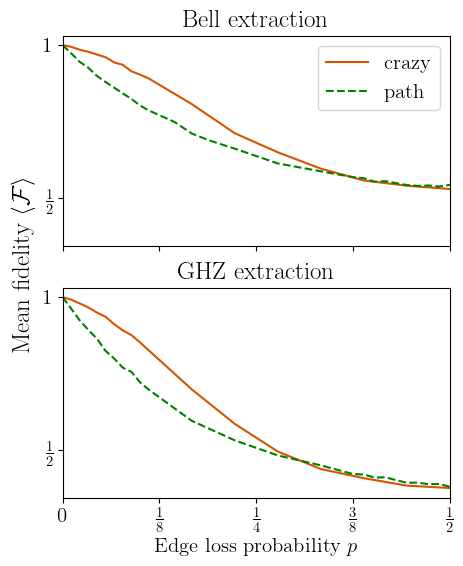

In [19]:
fig, (ax1, ax2) = plt.subplots(2,sharex=True,sharey=True,figsize=[5,6])

rc('font',**{'family':'serif','serif':['Palatino'],'size':15})
rc('text', usetex=True)

ax1.plot(xxs,yys,color="#d45500")
ax1.plot(xs,ys,'--',color="#008000")


ax2.plot(XXs,YYs,color="#d45500")
ax2.plot(Xs,Ys,'--',color="#008000")

ax1.legend(["crazy","path"])

plt.xlim(0,.5)

plt.rcParams['axes.facecolor'] = '#ffffff80'
rc('font',**{'family':'serif','serif':['Palatino Linotype'],'size':15})
rc('text', usetex=True)


fig.supylabel("Mean fidelity $\\langle\\mathcal{F}\\rangle$")
plt.xlabel("Edge loss probability $p$")
ax1.set_title("Bell extraction")
ax2.set_title("GHZ extraction")
ax1.set_yticks([.5,1])
ax1.set_yticklabels(["$\\frac12$","1"])
ax2.set_yticks([.5,1])
ax2.set_yticklabels(["$\\frac12$","1"])
ax2.set_xticks([0,1/8,2/8,3/8,4/8])
ax2.set_xticklabels(["0","$\\frac18$","$\\frac14$","$\\frac38$","$\\frac12$"])

In [25]:
# graphs for the upper part of the plot:

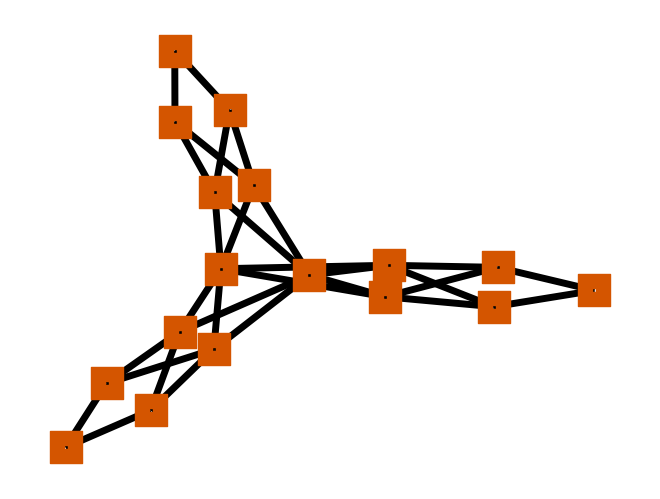

In [20]:
graph=prepare_crazy_cross(3,3)
graph.nodes
random.seed(2137900)
pos={vertex: (random.random(), random.random()) for vertex in graph.nodes}
pos[15]=(0.2,-0.03)
pos[16]=(-0.1,0.00)
pos=nx.spring_layout(graph,seed=2137,fixed=[15,16],pos=pos)
nx.draw(graph,pos,node_shape=own4a,node_color='#d45500',node_size=500,width=5,with_labels=False)

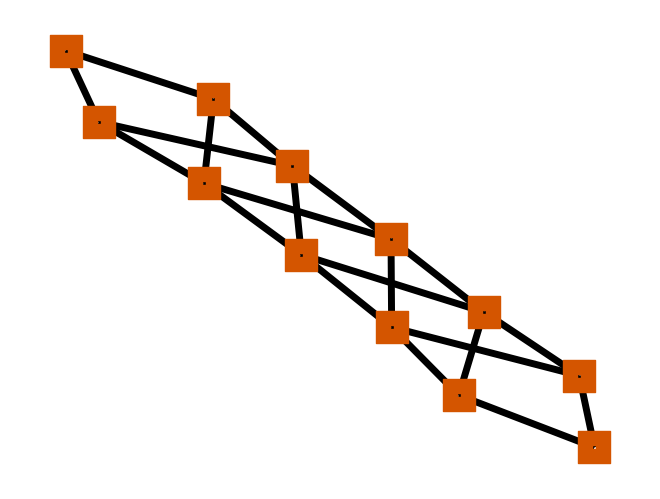

In [14]:
pos=nx.spring_layout(prepare_crazy_cross(3,2),seed=2137)
nx.draw(prepare_crazy_cross(3,2),pos,node_shape=own4a,node_color='#d45500',node_size=500,width=5)

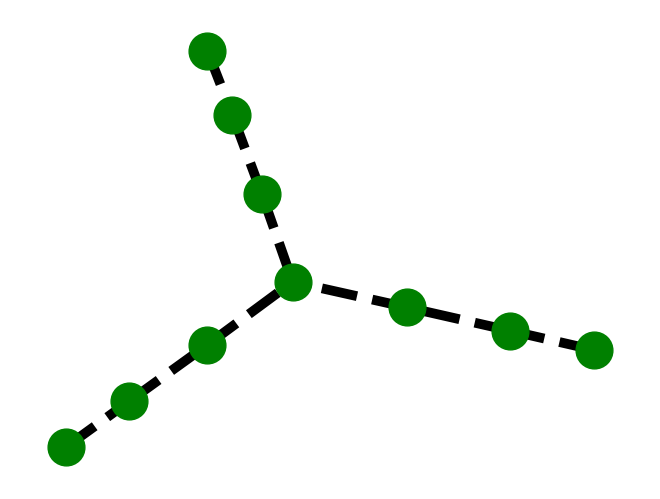

In [15]:
pos=nx.spring_layout(prepare_path_cross(3,3),seed=2137)
nx.draw(prepare_path_cross(3,3),pos,node_shape=owncirc,node_color='#008000',node_size=700,style='dashed',width=7)

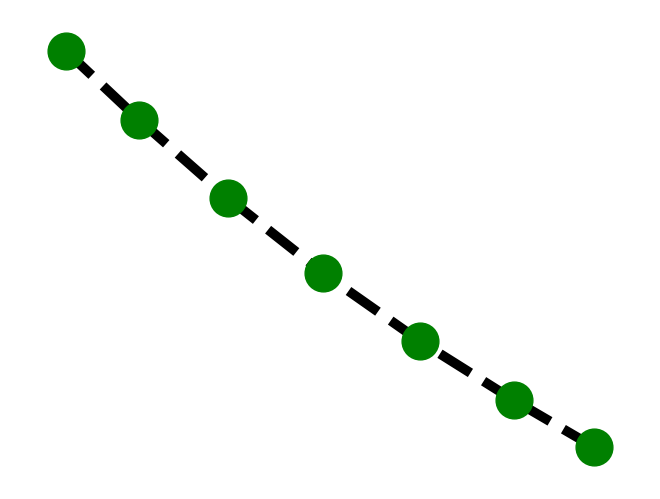

In [16]:
pos=nx.spring_layout(prepare_path_cross(3,2),seed=213901)
nx.draw(prepare_path_cross(3,2),pos,node_shape=owncirc,node_color='#008000',node_size=700,style='dashed',width=7)
